In [6]:
print('sadf')

sadf


In [7]:
import os
from dotenv import load_dotenv

In [8]:
# Load environment variables from .env file
load_dotenv()
groq_api_key = os.getenv("GROQ_API")
#print(f"GROQ API Key: {groq_api_key}")
os.environ["GROQ_API"] = groq_api_key

In [9]:
# check the api key response
from langchain_groq import ChatGroq
from langchain_core.tools import tool
from pydantic import BaseModel,Field,field_validator
import re
import pandas as pd
from typing import Literal,List,Optional,Any
from typing_extensions import Annotated

In [10]:
model=ChatGroq(model="openai/gpt-oss-120b",temperature=0,api_key=os.environ["GROQ_API"])
response=model.invoke("Hello, how are you?")
response

AIMessage(content="Hello! I'm doing great, thank you for asking. How can I assist you today?", additional_kwargs={'reasoning_content': 'We need to respond as ChatGPT. The user says "Hello, how are you?" We should respond politely. No policy issues.'}, response_metadata={'token_usage': {'completion_tokens': 55, 'prompt_tokens': 77, 'total_tokens': 132, 'completion_time': 0.113683264, 'completion_tokens_details': {'reasoning_tokens': 28}, 'prompt_time': 0.002862452, 'prompt_tokens_details': None, 'queue_time': 0.049900657, 'total_time': 0.116545716}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_70d048ba3c', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--e677d140-488d-40f2-90c6-6e6940bd37c4-0', usage_metadata={'input_tokens': 77, 'output_tokens': 55, 'total_tokens': 132, 'output_token_details': {'reasoning': 28}})

In [11]:
response.content

"Hello! I'm doing great, thank you for asking. How can I assist you today?"

In [12]:
# validatet the date colum in the dataframe(15-08-2024 13:30)
from pydantic import BaseModel
class DateValidator(BaseModel):
    date: str
    @field_validator('date')
    def validate_date(cls, v):
        import re
        pattern = r'^\d{2}-\d{2}-\d{4}$'
        if not re.match(pattern, v):
            raise ValueError('Date must be in DD-MM-YYYY format')
        return v
obj=DateValidator(date="12-04-2024")
print(obj)

date='12-04-2024'


In [13]:
class DateTimeModel(BaseModel):
    date_time:str
    @field_validator('date_time')
    def validate_date_time(cls,v):
        if not re.match(r'^\d{2}-\d{2}-\d{4} \d{2}:\d{2}$', v):
            raise ValueError('DateTime must be in DD-MM-YYYY HH:MM format')
        return v
obj=DateTimeModel(date_time="15-08-2024 13:30")
print(obj)        

date_time='15-08-2024 13:30'


In [14]:
class IdentifiactionNumberValidator(BaseModel):
    id:str
    @field_validator('id')
    def id_validator(cls,v):
        """it has only digits and length is 7 t0 8"""
        pattern=r'^\d{7,8}$'
        if not re.match(pattern,v):
            raise ValueError('ID must be 7 to 8 digits')
        return v
ob=IdentifiactionNumberValidator(id="12346987")
        
print(ob)

id='12346987'


In [15]:
import os
print(os.getcwd())


e:\doctor_appointment_booking_ageant\notebooks


In [16]:
data=pd.read_csv("doctor_availability.csv")
data.head()

,date_slot,specialization,doctor_name,is_available,patient_to_attend
0,05-08-2024 08:00,general_dentist,john doe,True,NaN
1,05-08-2024 08:30,general_dentist,john doe,False,1000082.0
2,05-08-2024 09:00,general_dentist,john doe,False,1000048.0
3,05-08-2024 09:30,general_dentist,john doe,False,1000036.0
4,05-08-2024 10:00,general_dentist,john doe,False,1000024.0


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4280 entries, 0 to 4279
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date_slot          4280 non-null   object 
 1   specialization     4280 non-null   object 
 2   doctor_name        4280 non-null   object 
 3   is_available       4280 non-null   bool   
 4   patient_to_attend  1567 non-null   float64
dtypes: bool(1), float64(1), object(3)
memory usage: 138.1+ KB


In [18]:
data['doctor_name'].unique()

array(['john doe', 'emily johnson', 'jane smith', 'lisa brown',
       'michael green', 'sarah wilson', 'daniel miller', 'susan davis',
       'robert martinez', 'kevin anderson'], dtype=object)

In [19]:
data['specialization'].unique()

array(['general_dentist', 'cosmetic_dentist', 'prosthodontist',
       'pediatric_dentist', 'emergency_dentist', 'oral_surgeon',
       'orthodontist'], dtype=object)

In [20]:
# create a tool for availability check the doctor based on date
@tool
def check_doctor_availability(desired_date:DateValidator ,doctor_name:Literal['kevin anderson','robert martinez','susan davis','daniel miller','sarah wilson','michael green','lisa brown','jane smith','emily johnson','john doe'])->str:
    """Check the availability of doctor on given date
    Args:
        desired_date (DateValidator): date in DD-MM-YYYY format
        doctor_name (Literal): name of the doctor
    Returns:
        str: availability of the doctor slots  on given date
    """
    df=pd.read_csv("doctor_availability.csv")
    df['date_slot_time'] = df['date_slot'].apply(lambda input: input.split(' ')[-1])
    
    rows = list(df[(df['date_slot'].apply(lambda input: input.split(' ')[0]) == desired_date.date)&(df['doctor_name'] == doctor_name)&(df['is_available'] == True)]['date_slot_time'])

    if len(rows) == 0:
        output = "No availability in the entire day"
    else:
        output = f'This availability for {desired_date.date}\n'
        output += "Available slots: " + ', '.join(rows)

    return output
    

In [21]:
date_instance = DateValidator(date="03-09-2024")
print(date_instance)

date='03-09-2024'


In [22]:
print(check_doctor_availability.invoke({"desired_date": date_instance, "doctor_name": "kevin anderson"}))


This availability for 03-09-2024
Available slots: 11:30, 12:30, 13:00, 14:00, 14:30, 15:00, 15:30, 16:00, 16:30


In [23]:
@tool
def check_doctor_availability_by_specialization(
        desired_date: DateValidator,
        specialization: Literal[
            'general_dentist', 'cosmetic_dentist', 'prosthodontist',
            'pediatric_dentist', 'emergency_dentist', 'oral_surgeon',
            'orthodontist'
        ]) -> str:
    """Check the availability of doctor on a given date by specialization from the database. if available retuen the avlilable slotes in AM/PM format else return no availability
    
    args:
        desired_date (DateValidator): date in DD-MM-YYYY format
        specialization (Literal): specialization of the doctor
    returns:
        str: availability of the doctors with given specialization on the desired date"""

    df = pd.read_csv("doctor_availability.csv")

    df['date_slot_time'] = df['date_slot'].apply(lambda x: x.split(' ')[-1])
    df['date_only'] = df['date_slot'].apply(lambda x: x.split(' ')[0])

    mask = (
        (df['date_only'] == desired_date.date) &
        (df['specialization'] == specialization) &
        (df['is_available'] == True)
    )

    filtered = df[mask]

    if filtered.empty:
        return f"No availability in the entire day for {specialization}"

    rows = filtered.groupby(['doctor_name'])['date_slot_time'].apply(list).reset_index()

    def am_to_pm(time_str: str):
        hour, minute = map(int, time_str.split(':'))
        period = "AM"
        if hour >= 12:
            period = "PM"
            if hour > 12:
                hour -= 12
        elif hour == 0:
            hour = 12
        return f"{hour}:{minute:02d} {period}"

    output = f"Availability for {desired_date.date} ({specialization}):\n"

    for _, row in rows.iterrows():
        doctor = row['doctor_name']
        slots = "\n ".join([am_to_pm(t) for t in row['date_slot_time']])
        output += f"- Dr. {doctor}: {slots}\n"

    return output


In [24]:
date_instance = DateValidator(date="03-09-2024")
print(check_doctor_availability_by_specialization.invoke({"desired_date": date_instance, "specialization": "orthodontist"}))

Availability for 03-09-2024 (orthodontist):
- Dr. kevin anderson: 11:30 AM
 12:30 PM
 1:00 PM
 2:00 PM
 2:30 PM
 3:00 PM
 3:30 PM
 4:00 PM
 4:30 PM



In [25]:
@tool
def set_appointment(desired_date:DateTimeModel, id_number:IdentifiactionNumberValidator, doctor_name:Literal['kevin anderson','robert martinez','susan davis','daniel miller','sarah wilson','michael green','lisa brown','jane smith','emily johnson','john doe']):
    """
    
    Check  the available slots. it is available Set appointment slot with the doctor.
    The parameters MUST be mentioned by the user in the query.
    
    args:
        desired_date (DateTimeModel): date and time in DD-MM-YYYY HH:MM format
        id_number (IdentifiactionNumberValidator): identification number of the patient
        doctor_name (Literal): name of the doctor
    returns:
        str: confirmation message of the appointment setting"""
    df = pd.read_csv(r"doctor_availability.csv")
   
    from datetime import datetime
    def convert_datetime_format(dt_str):
        dt = datetime.strptime(dt_str, "%d-%m-%Y %H:%M")
        return dt.strftime("%d-%m-%Y %H:%M")  # Also fix the format string here
    
    formatted_datetime = convert_datetime_format(desired_date.date_time)
    
    case = df[(df['date_slot'] == formatted_datetime) & (df['doctor_name'] == doctor_name) & (df['is_available'] == True)]
    
    if len(case) == 0:
        return "No available appointments for that particular case"
    else:
        df.loc[(df['date_slot'] == formatted_datetime) & (df['doctor_name'] == doctor_name) & (df['is_available'] == True), ['is_available','patient_to_attend']] = [False, int(id_number.id)]
        df.to_csv(r"doctor_availability.csv", index=False)
        return "Successfully done"

In [26]:
d= DateTimeModel(date_time="03-09-2024 08:30")
d
id=IdentifiactionNumberValidator(id="1234567")
id
print(set_appointment.invoke({"desired_date": d, "id_number": id, "doctor_name": "kevin anderson"}))

No available appointments for that particular case


In [27]:
# Create instances for booking an appointment
date_for_booking = DateTimeModel(date_time="03-09-2024 08:00")
patient_id = IdentifiactionNumberValidator(id="1234568")

In [28]:
print(check_doctor_availability_by_specialization.invoke({"desired_date": DateValidator(date="03-09-2024"), "specialization": "orthodontist"}))

Availability for 03-09-2024 (orthodontist):
- Dr. kevin anderson: 11:30 AM
 12:30 PM
 1:00 PM
 2:00 PM
 2:30 PM
 3:00 PM
 3:30 PM
 4:00 PM
 4:30 PM



In [29]:
print(set_appointment.invoke({"desired_date":date_for_booking,"id_number":patient_id,"doctor_name":"kevin anderson"}))

No available appointments for that particular case


In [30]:
@tool
def cancel_appointment(desired_date:DateTimeModel, id_number:IdentifiactionNumberValidator, doctor_name:Literal['kevin anderson','robert martinez','susan davis','daniel miller','sarah wilson','michael green','lisa brown','jane smith','emily johnson','john doe']):
    """
    Check the appointement. Cancel appointment slot with the doctor.
    The parameters MUST be mentioned by the user in the query.
    
    args:
        desired_date (DateTimeModel): date and time in DD-MM-YYYY HH:MM format
        id_number (IdentifiactionNumberValidator): identification number of the patient
        doctor_name (Literal): name of the doctor
    returns:
        str: confirmation message of the appointment cancellation
     
    """
    
    df = pd.read_csv(r"doctor_availability.csv")
   
    from datetime import datetime
    def convert_datetime_format(dt_str):
        dt = datetime.strptime(dt_str, "%d-%m-%Y %H:%M")
        # Match the exact format in CSV: DD-MM-YYYY HH:MM
        return dt.strftime("%d-%m-%Y %H:%M")
    
    formatted_date = convert_datetime_format(desired_date.date_time)
    
    # Convert id to float to match the CSV data type
    patient_id_float = float(id_number.id)
    
    case = df[
        (df['date_slot'] == formatted_date) & 
        (df['doctor_name'] == doctor_name) & 
        (df['patient_to_attend'] == patient_id_float)
    ]
    
    if len(case) == 0:
        return "No appointment found for that particular case to cancel"
    else:
        df.loc[
            (df['date_slot'] == formatted_date) & 
            (df['doctor_name'] == doctor_name) & 
            (df['patient_to_attend'] == patient_id_float), 
            ['is_available', 'patient_to_attend']
        ] = [True, None]
        
        df.to_csv(r"doctor_availability.csv", index=False)  # Remove the leading space!
        return "Successfully cancelled the appointment"

In [31]:
print(cancel_appointment.invoke({"desired_date":date_for_booking,"id_number":patient_id,"doctor_name":"kevin anderson"}))

No appointment found for that particular case to cancel


In [32]:
@tool
def reschedule_appointment(
    desired_date: DateTimeModel, 
    id_number: IdentifiactionNumberValidator, 
    doctor_name: Literal['kevin anderson','robert martinez','susan davis','daniel miller','sarah wilson','michael green','lisa brown','jane smith','emily johnson','john doe'], 
    new_date: DateTimeModel
):
    """
    Reschedule appointment or slot with the doctor.
    The parameters MUST be mentioned by the user in the query.
    Requires: current appointment date/time, patient ID, doctor name, and new desired date/time.
    
    args:
        desired_date (DateTimeModel): current appointment date and time in DD-MM-YYYY HH:MM format
        id_number (IdentifiactionNumberValidator): identification number of the patient
        doctor_name (Literal): name of the doctor
        new_date (DateTimeModel): new desired appointment date and time in DD-MM-YYYY HH:MM format
    returns:
        str: confirmation message of the appointment rescheduling
    """
    
    # First check if new slot is available (before canceling)
    df = pd.read_csv(r"doctor_availability.csv")
    from datetime import datetime
    
    def convert_datetime_format(dt_str):
        dt = datetime.strptime(dt_str, "%d-%m-%Y %H:%M")
        return dt.strftime("%d-%m-%Y %H:%M")
    
    new_formatted = convert_datetime_format(new_date.date_time)
    new_slot_check = df[
        (df['date_slot'] == new_formatted) & 
        (df['doctor_name'] == doctor_name) & 
        (df['is_available'] == True)
    ]
    
    if len(new_slot_check) == 0:
        return f"Cannot reschedule: New time slot {new_date.date_time} is not available"
    
    # Now proceed with cancellation and rebooking
    cancel_result = cancel_appointment.invoke({
        "desired_date": desired_date, 
        "id_number": id_number, 
        "doctor_name": doctor_name
    })
    
    if "Successfully cancelled" in cancel_result:
        set_result = set_appointment.invoke({
            "desired_date": new_date, 
            "id_number": id_number, 
            "doctor_name": doctor_name
        })
        
        if "Successfully done" in set_result:
            return f"Successfully rescheduled appointment from {desired_date.date_time} to {new_date.date_time}"
        else:
            # Try to restore the original appointment
            restore = set_appointment.invoke({
                "desired_date": desired_date, 
                "id_number": id_number, 
                "doctor_name": doctor_name
            })
            return f"Failed to book new slot. Original appointment restored: {restore}"
    else:
        return f"Cannot reschedule: {cancel_result}"

In [33]:
print(set_appointment.invoke({"desired_date":date_for_booking,"id_number":patient_id,"doctor_name":"kevin anderson"}))

No available appointments for that particular case


In [34]:
print(cancel_appointment.invoke({"desired_date":date_for_booking,"id_number":patient_id,"doctor_name":"kevin anderson"}))

No appointment found for that particular case to cancel


In [35]:
print(check_doctor_availability_by_specialization.invoke({"desired_date": DateValidator(date="03-09-2024"), "specialization": "orthodontist"}))

Availability for 03-09-2024 (orthodontist):
- Dr. kevin anderson: 11:30 AM
 12:30 PM
 1:00 PM
 2:00 PM
 2:30 PM
 3:00 PM
 3:30 PM
 4:00 PM
 4:30 PM



In [36]:
new_date_for_booking = DateTimeModel(date_time="03-09-2024 12:00")
id=IdentifiactionNumberValidator(id="12347999")
print(reschedule_appointment.invoke({"desired_date":date_for_booking,"id_number":id,"doctor_name":"kevin anderson","new_date":new_date_for_booking}))


Cannot reschedule: New time slot 03-09-2024 12:00 is not available


In [37]:
# check reshedule appointment tool
booking_id=IdentifiactionNumberValidator(id="87654321")
date= DateValidator(date="03-09-2024")
print(check_doctor_availability_by_specialization.invoke(
    {"desired_date": date, "specialization": "orthodontist"}
))

Availability for 03-09-2024 (orthodontist):
- Dr. kevin anderson: 11:30 AM
 12:30 PM
 1:00 PM
 2:00 PM
 2:30 PM
 3:00 PM
 3:30 PM
 4:00 PM
 4:30 PM



In [38]:
set_for_booking=DateTimeModel(date_time="03-09-2024 08:00")
print(set_appointment.invoke({"desired_date":set_for_booking,"id_number":booking_id,"doctor_name":"kevin anderson"}))

No available appointments for that particular case


In [39]:
# check reshedule appointment tool
booking_id=IdentifiactionNumberValidator(id="87654321")
date= DateValidator(date="03-09-2024")
print(check_doctor_availability_by_specialization.invoke(
    {"desired_date": date, "specialization": "orthodontist"}
))

Availability for 03-09-2024 (orthodontist):
- Dr. kevin anderson: 11:30 AM
 12:30 PM
 1:00 PM
 2:00 PM
 2:30 PM
 3:00 PM
 3:30 PM
 4:00 PM
 4:30 PM



In [40]:
new_date_for_booking = DateTimeModel(date_time="03-09-2024 12:00")
print(reschedule_appointment.invoke({"desired_date":set_for_booking,"id_number":booking_id,"doctor_name":"kevin anderson","new_date":new_date_for_booking}))

Cannot reschedule: New time slot 03-09-2024 12:00 is not available


## setting agent state

In [41]:
from langgraph.graph import add_messages
from typing_extensions import Annotated, TypedDict
class AgentState(TypedDict):
    messages: Annotated[List[Any], add_messages]
    id_number: int
    next: str
    query: str
    current_reasoning: str

In [42]:
members_dict = {'information_node':'specialized agent to provide information related to availability of doctors or any FAQs related to hospital.','booking_node':'specialized agent to only to book, cancel or reschedule appointment'}
members_dict


{'information_node': 'specialized agent to provide information related to availability of doctors or any FAQs related to hospital.',
 'booking_node': 'specialized agent to only to book, cancel or reschedule appointment'}

In [43]:
options = list(members_dict.keys()) + ["FINISH"]
options


['information_node', 'booking_node', 'FINISH']

In [44]:
worker_info = '\n\n'.join([f'WORKER: {member} \n DESCRIPTION: {description}' for member, description in members_dict.items()]) + '\n\nWORKER: FINISH \nDESCRIPTION: If User Query is answered and route to Finished'
print(worker_info)


WORKER: information_node 
 DESCRIPTION: specialized agent to provide information related to availability of doctors or any FAQs related to hospital.

WORKER: booking_node 
 DESCRIPTION: specialized agent to only to book, cancel or reschedule appointment

WORKER: FINISH 
DESCRIPTION: If User Query is answered and route to Finished


In [45]:
system_prompt = (
    "You are a supervisor tasked with managing a conversation between following workers. "
    "### SPECIALIZED ASSISTANT:\n"
    f"{worker_info}\n\n"
    "Your primary role is to help the user make an appointment with the doctor and provide updates on FAQs and doctor's availability. "
    "If a customer requests to know the availability of a doctor or to book, reschedule, or cancel an appointment, "
    "delegate the task to the appropriate specialized workers. Given the following user request,"
    " respond with the worker to act next with json foramt. Each worker will perform a"
    " task and respond with their results and status. \n\n"
    
    "IMPORTANT CRITERIA FOR FINISH:\n"
    "1. If the last message in the conversation is from a worker (information_node or booking_node) and it answers the user's question, route to FINISH.\n"
    "2. If the worker asks the user a clarifying question, route to FINISH (so the user can reply).\n"
    "3. Only route back to a worker if the previous tool output indicates an error or if more steps are strictly required."
)

In [46]:
print(system_prompt)

You are a supervisor tasked with managing a conversation between following workers. ### SPECIALIZED ASSISTANT:
WORKER: information_node 
 DESCRIPTION: specialized agent to provide information related to availability of doctors or any FAQs related to hospital.

WORKER: booking_node 
 DESCRIPTION: specialized agent to only to book, cancel or reschedule appointment

WORKER: FINISH 
DESCRIPTION: If User Query is answered and route to Finished

Your primary role is to help the user make an appointment with the doctor and provide updates on FAQs and doctor's availability. If a customer requests to know the availability of a doctor or to book, reschedule, or cancel an appointment, delegate the task to the appropriate specialized workers. Given the following user request, respond with the worker to act next with json foramt. Each worker will perform a task and respond with their results and status. 

IMPORTANT CRITERIA FOR FINISH:
1. If the last message in the conversation is from a worker (in

In [ ]:
from langgraph.types import Command
from typing_extensions import Annotated,TypedDict
from langgraph.types import Command
# import react agent
from langchain_core.prompts import ChatPromptTemplate
from langgraph.prebuilt import create_react_agent
from langgraph.graph import START, StateGraph,END
from langchain_core.messages import HumanMessage,AIMessage
from langgraph.graph import START, END, StateGraph



In [48]:
class Router(TypedDict):
    next: Literal["information_node","booking_node","FINISH"]
    reasoning: str

In [49]:
def supervisor_node(state:AgentState) -> Command[Literal['information_node', 'booking_node', '__end__']]:
    print("**************************below is my state right after entering****************************")
    print(state)
    
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": f"user's identification number is {state['id_number']}"},
    ] + state["messages"]
    
    print("***********************this is my message*****************************************")
    print(messages)
    
    # query = state['messages'][-1].content if state["messages"] else ""
    query = ''
    if len(state['messages']) == 1:
        query = state['messages'][0].content
      
    print("************below is my query********************")    
    print(query)
    
    response =model.with_structured_output(Router).invoke(messages)
    print("*"*10,response,"*"*10)
    
    goto = response["next"]
    
    print("********************************this is my goto*************************")
    print(goto)
    
    print("********************************")
    print(response["reasoning"])
          
    if goto == "FINISH":
        goto = END
        
    print("**************************below is my state****************************")
    print(state)
    
    if query:
        return Command(goto=goto, update={'next': goto, 
                                          'query': query, 
                                          'current_reasoning': response["reasoning"],
                                          'messages': [HumanMessage(content=f"user's identification number is {state['id_number']}")]
                        })
    return Command(goto=goto, update={'next': goto, 
                                      'current_reasoning': response["reasoning"]}
    )

In [50]:
def information_node(state: AgentState) -> Command[Literal["supervisor"]]:
    print("*****************called information node************")
    
    system_prompt = """
You are the Information Agent for a hospital appointment system.

Your responsibilities:
1. If the user asks about doctor availability, call the appropriate tool (check_doctor_availability or check_doctor_availability_by_specialization).
2. If the user’s query is missing required information, ask ONE clarifying question.

CRITICAL INSTRUCTIONS:
- If you have successfully called a tool and obtained the availability (even if the result is "No slots"), **YOU MUST ANSWER THE USER with normal text**.
- Do NOT call a tool again if you already have the answer in your history.
- Assume the current year is 2024.
"""
    
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            ("placeholder", "{messages}")
        ]
    )
    
    information_agent = create_react_agent(
        model=model,
        tools=[check_doctor_availability, check_doctor_availability_by_specialization],
        prompt=prompt
    )
    
    result = information_agent.invoke(state)
    
    return Command(
        update={
            "messages": state["messages"] + [
                AIMessage(content=result["messages"][-1].content, name="information_node")
            ]
        },
        goto="supervisor",
    )

In [51]:
def booking_node(state: AgentState) -> Command[Literal["supervisor"]]:
    
    print("*****************called booking node************")
    
    booking_system_prompt = """
You are the Booking Agent in a hospital appointment system.

Your responsibilities:

1. When the user wants to SET, CHANGE, or CANCEL an appointment:
    → You MUST call EXACTLY one of these tools:
        - set_appointment
        - cancel_appointment
        - reschedule_appointment

2. If the user request is missing required information (example: missing date, doctor name, or ID number):
    → Ask ONE clear question to collect the missing information.
    → After receiving it, you MUST call the correct tool.

3. NEVER respond with normal text if a tool call is required.
4. You MAY answer normally only if the user is asking a general question NOT related to booking.
5. Always assume the current year is 2024.
"""

    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", booking_system_prompt),
            ("placeholder", "{messages}"),
        ]
    )

    booking_agent = create_react_agent(
        model=model,
        tools=[set_appointment, cancel_appointment, reschedule_appointment],
        prompt=prompt
    )

    result = booking_agent.invoke(state)

    return Command(
        update={
            "messages": state["messages"] + [
                AIMessage(
                    content=result["messages"][-1].content,
                    name="booking_node"
                )
            ]
        },
        goto="supervisor",
    )


In [52]:
# import StateGraph and create the state graph
from langgraph.graph import StateGraph, START, END

In [53]:
# create the state graph
graph=StateGraph(AgentState)
graph.add_node("supervisor",supervisor_node)
graph.add_node('information_node',information_node)
graph.add_node('booking_node',booking_node)
graph.add_edge(START,'supervisor')
app=graph.compile()


In [54]:
import langgraph

graph = app.get_graph()
print(graph)

Graph(nodes={'__start__': Node(id='__start__', name='__start__', data=RunnableCallable(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None), 'supervisor': Node(id='supervisor', name='supervisor', data=supervisor(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None), 'information_node': Node(id='information_node', name='information_node', data=information_node(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None), 'booking_node': Node(id='booking_node', name='booking_node', data=booking_node(tags=None, recurse=True, explode_args=False, func_accepts={}), metadata=None), '__end__': Node(id='__end__', name='__end__', data=None, metadata=None)}, edges=[Edge(source='__start__', target='supervisor', data=None, conditional=False), Edge(source='booking_node', target='supervisor', data=None, conditional=True), Edge(source='information_node', target='supervisor', data=None, conditional=True), Edge(source='supervisor', target

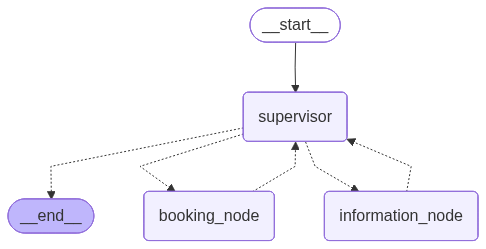

In [55]:

from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [56]:
inputs = [
        HumanMessage(content='can you check and make a booking if general dentist available on 8 August 2024 at 8 PM?')
    ]

In [57]:
state = {'messages': inputs,'id_number':10232303}


In [58]:
result = app.invoke(state)

**************************below is my state right after entering****************************
{'messages': [HumanMessage(content='can you check and make a booking if general dentist available on 8 August 2024 at 8 PM?', additional_kwargs={}, response_metadata={}, id='e3bb241c-acca-4356-88af-f848a1b69940')], 'id_number': 10232303}
***********************this is my message*****************************************
[{'role': 'system', 'content': "You are a supervisor tasked with managing a conversation between following workers. ### SPECIALIZED ASSISTANT:\nWORKER: information_node \n DESCRIPTION: specialized agent to provide information related to availability of doctors or any FAQs related to hospital.\n\nWORKER: booking_node \n DESCRIPTION: specialized agent to only to book, cancel or reschedule appointment\n\nWORKER: FINISH \nDESCRIPTION: If User Query is answered and route to Finished\n\nYour primary role is to help the user make an appointment with the doctor and provide updates on FAQ

C:\Users\VIJAY\AppData\Local\Temp\ipykernel_1788\3267701770.py:24: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  information_agent = create_react_agent(


**************************below is my state right after entering****************************
{'messages': [HumanMessage(content='can you check and make a booking if general dentist available on 8 August 2024 at 8 PM?', additional_kwargs={}, response_metadata={}, id='e3bb241c-acca-4356-88af-f848a1b69940'), HumanMessage(content="user's identification number is 10232303", additional_kwargs={}, response_metadata={}, id='ee003642-359f-4a4e-a8c5-2b48e582d8b9'), AIMessage(content='I checked the schedule for general‑dentist appointments on\u202f08‑08‑2024. None of the listed dentists have a slot at\u202f8\u202fPM that day—the available times are all in the morning and early afternoon.\n\nSince the requested 8\u202fPM slot isn’t open, I’m unable to make a booking for that time. If you’d like, I can look for an earlier slot on the same day or check other dates for a convenient time. Let me know how you’d like to proceed!', additional_kwargs={}, response_metadata={}, name='information_node', id='

C:\Users\VIJAY\AppData\Local\Temp\ipykernel_1788\3267701770.py:24: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  information_agent = create_react_agent(


**************************below is my state right after entering****************************
{'messages': [HumanMessage(content='can you check and make a booking if general dentist available on 8 August 2024 at 8 PM?', additional_kwargs={}, response_metadata={}, id='e3bb241c-acca-4356-88af-f848a1b69940'), HumanMessage(content="user's identification number is 10232303", additional_kwargs={}, response_metadata={}, id='ee003642-359f-4a4e-a8c5-2b48e582d8b9'), AIMessage(content='I checked the schedule for general‑dentist appointments on\u202f08‑08‑2024. None of the listed dentists have a slot at\u202f8\u202fPM that day—the available times are all in the morning and early afternoon.\n\nSince the requested 8\u202fPM slot isn’t open, I’m unable to make a booking for that time. If you’d like, I can look for an earlier slot on the same day or check other dates for a convenient time. Let me know how you’d like to proceed!', additional_kwargs={}, response_metadata={}, name='information_node', id='

C:\Users\VIJAY\AppData\Local\Temp\ipykernel_1788\3267701770.py:24: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  information_agent = create_react_agent(


**************************below is my state right after entering****************************
{'messages': [HumanMessage(content='can you check and make a booking if general dentist available on 8 August 2024 at 8 PM?', additional_kwargs={}, response_metadata={}, id='e3bb241c-acca-4356-88af-f848a1b69940'), HumanMessage(content="user's identification number is 10232303", additional_kwargs={}, response_metadata={}, id='ee003642-359f-4a4e-a8c5-2b48e582d8b9'), AIMessage(content='I checked the schedule for general‑dentist appointments on\u202f08‑08‑2024. None of the listed dentists have a slot at\u202f8\u202fPM that day—the available times are all in the morning and early afternoon.\n\nSince the requested 8\u202fPM slot isn’t open, I’m unable to make a booking for that time. If you’d like, I can look for an earlier slot on the same day or check other dates for a convenient time. Let me know how you’d like to proceed!', additional_kwargs={}, response_metadata={}, name='information_node', id='

In [59]:
result['messages'][-1].content

'I checked the schedule for general‑dentist appointments on\u202f08‑08‑2024. The available slots are:\n\n**Dr. Emily Johnson**\n- 8:00\u202fAM, 8:30\u202fAM, 10:00\u202fAM, 10:30\u202fAM, 11:00\u202fAM, 11:30\u202fAM, 12:00\u202fPM, 12:30\u202fPM, 1:30\u202fPM, 2:30\u202fPM, 3:30\u202fPM, 4:30\u202fPM  \n\n**Dr. John Doe**\n- 8:00\u202fAM, 9:00\u202fAM, 9:30\u202fAM, 10:00\u202fAM, 12:00\u202fPM, 1:30\u202fPM, 2:00\u202fPM, 3:00\u202fPM, 3:30\u202fPM, 4:00\u202fPM, 4:30\u202fPM  \n\nThere is no slot at\u202f8\u202fPM on that date.  \n\nWould you like to book one of the available morning/afternoon times, or should I check another date for an evening slot?'

In [ ]:
print(result['messages'][-1].content)

I checked the schedule for general‑dentist appointments on 08‑08‑2024. The available slots are:

**Dr. Emily Johnson**
- 8:00 AM, 8:30 AM, 10:00 AM, 10:30 AM, 11:00 AM, 11:30 AM, 12:00 PM, 12:30 PM, 1:30 PM, 2:30 PM, 3:30 PM, 4:30 PM  

**Dr. John Doe**
- 8:00 AM, 9:00 AM, 9:30 AM, 10:00 AM, 12:00 PM, 1:30 PM, 2:00 PM, 3:00 PM, 3:30 PM, 4:00 PM, 4:30 PM  

There is no slot at 8 PM on that date.  

Would you like to book one of the available morning/afternoon times, or should I check another date for an evening slot?


In [61]:
inputs = [
        HumanMessage(content='can you check and make a booking if general dentist available on 8 August 2024 at 8 AM?')
        
    ]
state = {'messages': inputs,'id_number':10232303}
print("**********invoking the app************")
result = app.invoke(state)
print("**********printing the result************")
print(result)

**********invoking the app************
**************************below is my state right after entering****************************
{'messages': [HumanMessage(content='can you check and make a booking if general dentist available on 8 August 2024 at 8 AM?', additional_kwargs={}, response_metadata={}, id='3491105d-11bf-478e-905b-d37fee2b2722')], 'id_number': 10232303}
***********************this is my message*****************************************
[{'role': 'system', 'content': "You are a supervisor tasked with managing a conversation between following workers. ### SPECIALIZED ASSISTANT:\nWORKER: information_node \n DESCRIPTION: specialized agent to provide information related to availability of doctors or any FAQs related to hospital.\n\nWORKER: booking_node \n DESCRIPTION: specialized agent to only to book, cancel or reschedule appointment\n\nWORKER: FINISH \nDESCRIPTION: If User Query is answered and route to Finished\n\nYour primary role is to help the user make an appointment wit

C:\Users\VIJAY\AppData\Local\Temp\ipykernel_1788\3267701770.py:24: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  information_agent = create_react_agent(


**************************below is my state right after entering****************************
{'messages': [HumanMessage(content='can you check and make a booking if general dentist available on 8 August 2024 at 8 AM?', additional_kwargs={}, response_metadata={}, id='3491105d-11bf-478e-905b-d37fee2b2722'), HumanMessage(content="user's identification number is 10232303", additional_kwargs={}, response_metadata={}, id='05a4c944-a376-460f-9ece-c67990647423'), AIMessage(content='I see that both Dr.\u202fEmily\u202fJohnson and Dr.\u202fJohn\u202fDoe have an 8\u202fAM slot on\u202f08‑08‑2024. Which doctor would you like to book the appointment with?', additional_kwargs={}, response_metadata={}, name='information_node', id='0c2c5916-e2fe-4f4a-9697-7fe4bdce110c')], 'id_number': 10232303, 'next': 'information_node', 'query': 'can you check and make a booking if general dentist available on 8 August 2024 at 8 AM?', 'current_reasoning': 'User wants to know if a general dentist is available on 8 Au